In [306]:
from classification_scripts import hold_out_set, eval_class_no_scaling, eval_class_no_scaling_ensembles
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

This breast cancer domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. 

This data set includes 201 instances of one class and 85 instances of another class.  The instances are described by 9 attributes, some of which are linear and some are nominal.

In [307]:
# Load the data
names = ['class', 'age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiat']
raw = pd.read_csv('../data/breast-cancer.data', header=None, names=names)

In [308]:
# make copy 
df = raw.copy()
# class imbalance within predictive variable
df.loc[:,'irradiat'].value_counts()

no     218
yes     68
Name: irradiat, dtype: int64

In [309]:
# only one categorial attribute present
#  will require creation of dummy variables
df.describe()

,deg_malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
class          286 non-null object
age            286 non-null object
menopause      286 non-null object
tumor_size     286 non-null object
inv_nodes      286 non-null object
node_caps      286 non-null object
deg_malig      286 non-null int64
breast         286 non-null object
breast_quad    286 non-null object
irradiat       286 non-null object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [311]:
# 9 missing values for node caps
df['node_caps'].value_counts()

no     222
yes     56
?        8
Name: node_caps, dtype: int64

In [312]:
# one missing value for brest_quad
df['breast_quad'].value_counts()

left_low     110
left_up       97
right_up      33
right_low     24
central       21
?              1
Name: breast_quad, dtype: int64

In [313]:
# cannot drop noe caps missing values and will ontribute for increase in class imbalance
df.loc[(df['breast_quad'] == '?') | (df['node_caps'] == '?')]

,class,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat
145,no-recurrence-events,40-49,premeno,25-29,0-2,?,2,left,right_low,yes
163,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_up,yes
164,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_low,yes
183,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_up,yes
184,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_low,yes
206,recurrence-events,50-59,ge40,30-34,0-2,no,3,left,?,no
233,recurrence-events,70-79,ge40,15-19,9-11,?,1,left,left_low,yes
263,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_up,no
264,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_low,no


In [314]:
# fill na for node caps to yes for now
df.loc[df['node_caps'] == '?','node_caps']  = 'yes'
df['node_caps'].value_counts()

no     222
yes     64
Name: node_caps, dtype: int64

In [315]:
# droping the breast quad missing value for now
df = df.loc[~(df['breast_quad'] == '?')]

#### Data transformation

Apart from degree of malignant all attributes are categorical. Choosing to create dummy variables for all. 
Attributes with binary outcome will default to 1 for the majority class (ie. class or node_caps)

In [316]:
df['class'] = np.where(df['class'] == 'no-recurrence-events', 0, 1)
df['node_caps'] = np.where(df['node_caps'] == 'no', 0, 1)
df['breast'] = np.where(df['breast'] == 'left', 0, 1)
df['irradiat'] = np.where(df['irradiat'] == 'yes', 1, 0)

In [317]:
age = pd.get_dummies(df['age'].copy())
age.sample(3)

,20-29,30-39,40-49,50-59,60-69,70-79
62,0,0,0,1,0,0
161,0,0,1,0,0,0
0,0,1,0,0,0,0


In [318]:
menopause = pd.get_dummies(df['menopause'].copy())
menopause.sample(3)

,ge40,lt40,premeno
239,0,0,1
219,0,0,1
224,0,0,1


In [319]:
tumor_size = pd.get_dummies(df['tumor_size'].copy())
tumor_size.sample(2)

,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54
99,0,0,0,0,1,0,0,0,0,0,0
148,0,0,0,1,0,0,0,0,0,0,0


In [320]:
breast_quad = pd.get_dummies(df['breast_quad'].copy())
breast_quad.sample(2)

,central,left_low,left_up,right_low,right_up
250,0,0,1,0,0
185,0,1,0,0,0


In [321]:
inv_nodes = pd.get_dummies(df['inv_nodes'])
inv_nodes.sample(2)

,0-2,12-14,15-17,24-26,3-5,6-8,9-11
9,1,0,0,0,0,0,0
152,0,0,1,0,0,0,0


In [322]:
deg_malig = pd.get_dummies(df['deg_malig'], prefix='deg_malig')
deg_malig.sample(2)

,deg_malig_1,deg_malig_2,deg_malig_3
103,0,1,0
196,1,0,0


In [323]:
new_frame = pd.concat([df['class'].copy(), age, menopause, tumor_size, inv_nodes, 
                       df['node_caps'].copy(), deg_malig, df['breast'].copy(), 
                       breast_quad, df['irradiat'].copy()], axis=1)

new_frame.sample(3)

,class,20-29,30-39,40-49,50-59,60-69,70-79,ge40,lt40,premeno,...,deg_malig_1,deg_malig_2,deg_malig_3,breast,central,left_low,left_up,right_low,right_up,irradiat
100,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
31,0,0,0,0,1,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
241,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [324]:
new_frame.describe()

,class,20-29,30-39,40-49,50-59,60-69,70-79,ge40,lt40,premeno,...,deg_malig_1,deg_malig_2,deg_malig_3,breast,central,left_low,left_up,right_low,right_up,irradiat
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,0.294737,0.003509,0.126316,0.315789,0.333333,0.200000,0.021053,0.449123,0.024561,0.526316,...,0.249123,0.456140,0.294737,0.470175,0.073684,0.385965,0.340351,0.084211,0.115789,0.238596
std,0.456726,0.059235,0.332789,0.465647,0.472234,0.400704,0.143812,0.498280,0.155056,0.500185,...,0.433266,0.498949,0.456726,0.499988,0.261716,0.487679,0.474661,0.278192,0.320535,0.426975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Evaluate Some Algorithms
Now it is time to create some models of the data and estimate their accuracy on unseen data.
Here is what we are going to cover in this step:
1. Separate out a validation dataset.
2. Setup the test harness to use 10-fold cross-validation.
3. Build 5 different models to predict irradiation variable
4. Select the best model.

In [325]:
new_frame.iloc[:,38]

0      0
1      0
2      0
3      0
4      0
      ..
281    0
282    1
283    0
284    0
285    0
Name: irradiat, Length: 285, dtype: int32

In [326]:
frames = hold_out_set(dataframe=new_frame, y_loc=38, seed=42)

C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are 

              LR        LDA        KNN       CART         NB
count  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.598637   0.616232   0.558210   0.582349   0.551540
std     0.039854   0.038419   0.039356   0.046539   0.050652
min     0.545509   0.560294   0.471008   0.487370   0.481303
25%     0.574144   0.585115   0.540172   0.553361   0.532120
50%     0.602369   0.611363   0.564358   0.573753   0.543143
75%     0.615074   0.647794   0.579202   0.613924   0.564391
max     0.715126   0.683440   0.643144   0.685294   0.688853


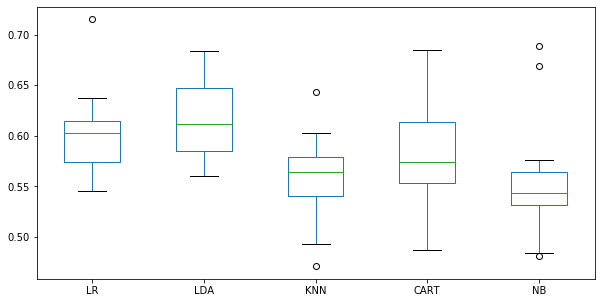

In [327]:
results=eval_class_no_scaling(frames.X_train, frames.y_train, 
                              seed=42, stratified=True, num_folds= 2, scoring='balanced_accuracy')

In [328]:
results

,LR,LDA,KNN,CART,NB
0,0.562751,0.579791,0.493585,0.579190,0.575782
1,0.613655,0.584244,0.589706,0.549580,0.481303
2,0.602847,0.677225,0.643144,0.544306,0.535084
3,0.577941,0.560294,0.583613,0.614076,0.564706
4,0.545509,0.585806,0.545509,0.487370,0.536087
5,0.715126,0.661975,0.565966,0.573529,0.535084
6,0.608861,0.683440,0.568565,0.642943,0.552526
7,0.601891,0.667437,0.471008,0.584454,0.552731
8,0.551524,0.608861,0.545710,0.521652,0.523857
9,0.620168,0.632143,0.590126,0.573109,0.564286


C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\FGiordano-Silva\AppData\Local\Continuum\miniconda3\envs\scripts\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defin

               AB         GBM          RF          ET
count  100.000000  100.000000  100.000000  100.000000
mean     0.323124    0.398064    0.372176    0.385445
std      0.186477    0.194956    0.197141    0.191050
min      0.000000    0.000000    0.000000    0.000000
25%      0.200000    0.250000    0.250000    0.250000
50%      0.333333    0.444444    0.400000    0.400000
75%      0.444444    0.545455    0.500000    0.545455
max      0.727273    0.727273    0.727273    0.727273


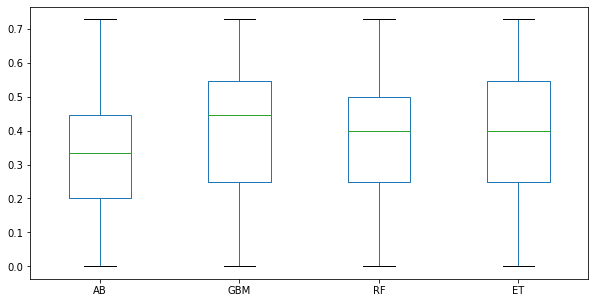

In [329]:
# not a performance boost with ensembles
results_ensamble = eval_class_no_scaling_ensembles(frames.X_train, frames.y_train, 
                                                   seed=42,stratified=True, scoring='f1')

#### Finalize the model

In [330]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(frames.X_train, frames.y_train)

predictions = model.predict(frames.X_hold_out)

print(accuracy_score(frames.y_hold_out, predictions))
print(confusion_matrix(frames.y_hold_out, predictions))
print(classification_report(frames.y_hold_out, predictions))
print(roc_auc_score(frames.y_hold_out, predictions))

0.7719298245614035
[[41  5]
 [ 8  3]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        46
           1       0.38      0.27      0.32        11

    accuracy                           0.77        57
   macro avg       0.61      0.58      0.59        57
weighted avg       0.75      0.77      0.76        57

0.5820158102766798


In [331]:
from sklearn.metrics import SCORERS

Based on the above results we are doing poorly for the predicting cases of irradiation. 

In [332]:
SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
 'balanced_accuracy': make_scorer(balanced_accuracy_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
 'brier_score_loss': make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'homog